<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/batch_size_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 10: Batch Size Impact
## Objective: Compare small vs large batch sizes on facial expression recognition performance

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
import time
import copy
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 84% 239M/285M [00:00<00:00, 786MB/s] 
100% 285M/285M [00:00<00:00, 815MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [6]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


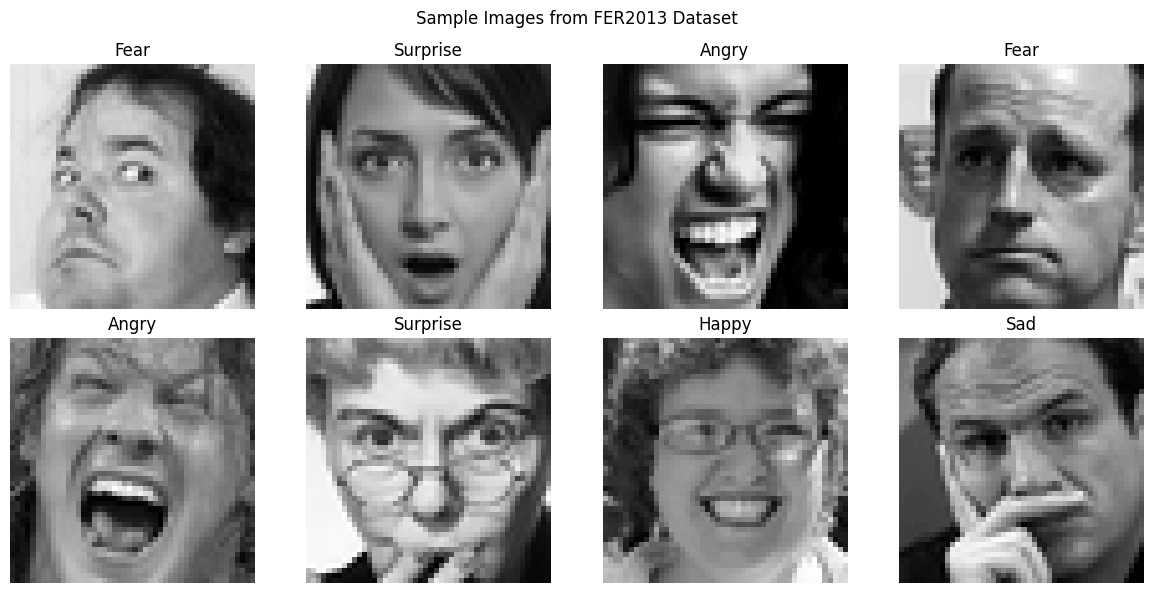

In [7]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
plt.show()

In [8]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [9]:
# Create base dataset
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Train size: 22967
Validation size: 5742


In [10]:
# CNN Model for Batch Size Testing
class BatchSizeTestCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BatchSizeTestCNN, self).__init__()

        # Conv Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.1)

        # Conv Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.2)

        # Conv Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(256, num_classes)

        # Activation
        self.relu = nn.ReLU(inplace=True)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Conv Block 2
        x = self.relu(self.bn2_1(self.conv2_1(x)))
        x = self.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Conv Block 3
        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)

        x = self.fc3(x)

        return x

In [11]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a sample model to check parameter count
sample_model = BatchSizeTestCNN().to(device)
total_params = sample_model.total_params
print(f"Total parameters: {total_params:,}")
del sample_model

Using device: cuda
Total parameters: 5,999,815


In [12]:
# Define batch size configurations
batch_size_configs = {
    'Small_16': {
        'batch_size': 16,
        'lr': 0.001,
        'description': 'Small batch (16)',
        'color': 'red',
        'marker': 'o'
    },
    'Medium_64': {
        'batch_size': 64,
        'lr': 0.001,
        'description': 'Medium batch (64)',
        'color': 'blue',
        'marker': 's'
    },
    'Large_128': {
        'batch_size': 128,
        'lr': 0.0015,  # Slightly higher LR for larger batch
        'description': 'Large batch (128)',
        'color': 'green',
        'marker': '^'
    },
    'XLarge_256': {
        'batch_size': 256,
        'lr': 0.002,  # Higher LR for very large batch
        'description': 'Extra Large batch (256)',
        'color': 'purple',
        'marker': 'D'
    }
}

print("Batch Size Configurations:")
print("=" * 60)
for name, config in batch_size_configs.items():
    print(f"{config['description']}: Batch size={config['batch_size']}, LR={config['lr']}")
print("=" * 60)

Batch Size Configurations:
Small batch (16): Batch size=16, LR=0.001
Medium batch (64): Batch size=64, LR=0.001
Large batch (128): Batch size=128, LR=0.0015
Extra Large batch (256): Batch size=256, LR=0.002


In [13]:
# Training function with timing
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    gradient_norms = []

    for batch_idx, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Calculate gradient norm
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        gradient_norms.append(total_norm)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    avg_gradient_norm = np.mean(gradient_norms)

    return epoch_loss, epoch_acc, epoch_time, avg_gradient_norm

In [14]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, epoch_time, all_predictions, all_labels

In [15]:
# Train models with different batch sizes
results = {}
num_epochs = 20

for config_name, config in batch_size_configs.items():
    print(f"\n{'='*70}")
    print(f"Training with {config['description']}")
    print(f"{'='*70}")

    # Create data loaders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                             shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                           shuffle=False, num_workers=2)

    print(f"Batches per epoch: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")

    # Initialize W&B run for this batch size
    wandb.init(
        project="fer-challenge",
        name=f"exp10-batch-{config_name.lower()}",
        config={
            "architecture": "CNN for Batch Size Comparison",
            "dataset": "FER2013",
            "epochs": num_epochs,
            "batch_size": config['batch_size'],
            "learning_rate": config['lr'],
            "optimizer": "Adam",
            "weight_decay": 1e-4,
            "num_classes": 7
        }
    )

    # Initialize model
    model = BatchSizeTestCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)

    # Track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    train_times = []
    val_times = []
    gradient_norms = []
    best_val_acc = 0

    # Log model to W&B
    wandb.watch(model, log='all')

    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs} - {config["description"]}')
        print('-' * 50)

        # Train
        train_loss, train_acc, train_time, grad_norm = train_epoch(
            model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_times.append(train_time)
        gradient_norms.append(grad_norm)

        # Validate
        val_loss, val_acc, val_time, predictions, labels = validate_epoch(
            model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_times.append(val_time)

        # Log to W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'train_time': train_time,
            'val_time': val_time,
            'gradient_norm': grad_norm,
            'overfitting_gap': train_acc - val_acc,
            'samples_per_second': len(train_dataset) / train_time
        })

        print(f'Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%, Time={train_time:.1f}s')
        print(f'Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, Time={val_time:.1f}s')
        print(f'Gradient Norm: {grad_norm:.4f}')
        print(f'Samples/sec: {len(train_dataset)/train_time:.1f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{config_name.lower()}_model.pth')

    # Store results
    results[config_name] = {
        'config': config,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'train_times': train_times,
        'val_times': val_times,
        'gradient_norms': gradient_norms,
        'best_val_acc': best_val_acc,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'avg_train_time': np.mean(train_times),
        'total_train_time': sum(train_times),
        'avg_gradient_norm': np.mean(gradient_norms),
        'model': model
}
print(f"\n{config['description']} - Best Val Acc: {best_val_acc:.2f}%")
print(f"Average training time per epoch: {np.mean(train_times):.1f}s")
print(f"Total training time: {sum(train_times):.1f}s")
# Finish W&B run
wandb.finish()



Training with Small batch (16)
Batches per epoch: 1436
Validation batches: 359


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/20 - Small batch (16)
--------------------------------------------------
Train: Loss=1.6498, Acc=34.42%, Time=32.3s
Val: Loss=1.3634, Acc=47.53%, Time=5.2s
Gradient Norm: 3.4752
Samples/sec: 711.9

Epoch 2/20 - Small batch (16)
--------------------------------------------------
Train: Loss=1.3747, Acc=47.12%, Time=30.0s
Val: Loss=1.2460, Acc=52.18%, Time=4.5s
Gradient Norm: 2.6830
Samples/sec: 765.4

Epoch 3/20 - Small batch (16)
--------------------------------------------------
Train: Loss=1.2935, Acc=50.46%, Time=30.1s
Val: Loss=1.2175, Acc=53.67%, Time=6.6s
Gradient Norm: 2.3998
Samples/sec: 763.1

Epoch 4/20 - Small batch (16)
--------------------------------------------------
Train: Loss=1.2372, Acc=52.68%, Time=29.1s
Val: Loss=1.1605, Acc=55.87%, Time=4.9s
Gradient Norm: 2.2305
Samples/sec: 788.5

Epoch 5/20 - Small batch (16)
--------------------------------------------------
Train: Loss=1.1952, Acc=54.50%, Time=29.7s
Val: Loss=1.1691, Acc=56.13%, Time=4.4s
Gradient No

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
gradient_norm,█▄▃▂▂▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆
overfitting_gap,▁▃▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇██
samples_per_second,▁▆▆█▇▇▆▆▇▆▇▇▆▇▆▆▆▅▄▆
train_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_time,█▃▃▁▂▂▃▃▂▃▂▂▂▂▃▃▃▄▅▃
val_acc,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_loss,█▅▅▄▄▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁
val_time,▃▁▇▂▁▇▁▁█▁▁▇▁▁▇▁▁█▂▄
epoch,20



Epoch 1/20 - Medium batch (64)
--------------------------------------------------
Train: Loss=1.6225, Acc=35.83%, Time=20.5s
Val: Loss=1.3698, Acc=47.56%, Time=4.4s
Gradient Norm: 2.3835
Samples/sec: 1123.0

Epoch 2/20 - Medium batch (64)
--------------------------------------------------
Train: Loss=1.3152, Acc=49.55%, Time=22.2s
Val: Loss=1.2335, Acc=52.56%, Time=3.9s
Gradient Norm: 1.7430
Samples/sec: 1034.3

Epoch 3/20 - Medium batch (64)
--------------------------------------------------
Train: Loss=1.2073, Acc=53.18%, Time=21.6s
Val: Loss=1.1416, Acc=57.07%, Time=4.8s
Gradient Norm: 1.6618
Samples/sec: 1061.9

Epoch 4/20 - Medium batch (64)
--------------------------------------------------
Train: Loss=1.1337, Acc=56.60%, Time=20.3s
Val: Loss=1.1268, Acc=57.94%, Time=4.8s
Gradient Norm: 1.5935
Samples/sec: 1133.5

Epoch 5/20 - Medium batch (64)
--------------------------------------------------
Train: Loss=1.0808, Acc=58.80%, Time=21.6s
Val: Loss=1.1059, Acc=58.81%, Time=3.9s
Gr

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
gradient_norm,█▃▂▂▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅
overfitting_gap,▁▃▂▃▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇█
samples_per_second,▇▂▄█▄▄▇▅▄▇▅▁▇▆▁▇▇▂▅▇
train_acc,▁▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁
train_time,▂▆▅▁▅▅▂▄▅▂▄█▂▃█▂▂▇▄▂
val_acc,▁▃▅▆▆▇▇▇▇▇▇█▇▇█████▇
val_loss,▇▄▃▂▂▁▁▁▁▁▂▁▂▃▃▄▄▆▆█
val_time,▃▁▄▄▁▄▅▁▃▆▁▁▇▁▁█▁▁▅▃
epoch,20



Epoch 1/20 - Large batch (128)
--------------------------------------------------
Train: Loss=1.6815, Acc=32.76%, Time=19.3s
Val: Loss=1.4954, Acc=43.30%, Time=3.9s
Gradient Norm: 1.6266
Samples/sec: 1187.1

Epoch 2/20 - Large batch (128)
--------------------------------------------------
Train: Loss=1.3530, Acc=47.76%, Time=22.0s
Val: Loss=1.2518, Acc=53.03%, Time=3.8s
Gradient Norm: 1.2147
Samples/sec: 1043.5

Epoch 3/20 - Large batch (128)
--------------------------------------------------
Train: Loss=1.2198, Acc=53.16%, Time=19.2s
Val: Loss=1.1650, Acc=55.31%, Time=5.1s
Gradient Norm: 1.1439
Samples/sec: 1198.0

Epoch 4/20 - Large batch (128)
--------------------------------------------------
Train: Loss=1.1392, Acc=56.54%, Time=20.1s
Val: Loss=1.1510, Acc=56.55%, Time=3.8s
Gradient Norm: 1.1047
Samples/sec: 1142.2

Epoch 5/20 - Large batch (128)
--------------------------------------------------
Train: Loss=1.0805, Acc=59.12%, Time=20.1s
Val: Loss=1.0769, Acc=58.66%, Time=5.3s
Gr

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
gradient_norm,█▃▂▂▁▁▁▁▁▁▂▂▂▃▃▄▅▅▅▅
overfitting_gap,▁▂▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
samples_per_second,▇▁█▅▅▇▃█▄▆▇▂▇▅▆█▄▆▃▆
train_acc,▁▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
train_time,▁█▁▃▃▂▆▁▄▃▂▆▂▄▃▁▄▃▆▃
val_acc,▁▅▅▆▇▇▆▇▇▇█▇██████▇▇
val_loss,█▄▃▂▁▁▂▁▁▂▁▂▂▃▃▄▄▅▇▇
val_time,▂▁▆▁▆▁▁▄▂▇▁▁▄▁█▁▄▂▃█
epoch,20



Epoch 1/20 - Extra Large batch (256)
--------------------------------------------------
Train: Loss=1.6794, Acc=32.90%, Time=19.1s
Val: Loss=1.5015, Acc=42.25%, Time=5.3s
Gradient Norm: 1.2358
Samples/sec: 1200.9

Epoch 2/20 - Extra Large batch (256)
--------------------------------------------------
Train: Loss=1.3713, Acc=47.18%, Time=19.4s
Val: Loss=1.2767, Acc=51.32%, Time=3.7s
Gradient Norm: 0.9033
Samples/sec: 1186.1

Epoch 3/20 - Extra Large batch (256)
--------------------------------------------------
Train: Loss=1.2307, Acc=52.86%, Time=19.3s
Val: Loss=1.2044, Acc=53.88%, Time=5.5s
Gradient Norm: 0.8775
Samples/sec: 1188.1

Epoch 4/20 - Extra Large batch (256)
--------------------------------------------------
Train: Loss=1.1396, Acc=56.51%, Time=18.9s
Val: Loss=1.1139, Acc=57.66%, Time=3.7s
Gradient Norm: 0.8467
Samples/sec: 1216.9

Epoch 5/20 - Extra Large batch (256)
--------------------------------------------------
Train: Loss=1.0773, Acc=58.96%, Time=20.2s
Val: Loss=1.

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
gradient_norm,█▃▂▂▂▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄
overfitting_gap,▁▂▃▃▃▃▄▄▄▄▅▅▅▆▆▇▇▇██
samples_per_second,▇▇▇█▅▁▇▅▆▄█▆▇▇▇▇▅▇▄▇
train_acc,▁▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
train_time,▂▂▂▁▃█▂▃▂▄▁▂▂▂▂▂▄▁▄▂
val_acc,▁▄▅▇▆▇▇▇██▇▇████████
val_loss,█▄▃▂▃▁▂▂▁▁▂▂▂▃▃▄▅▅▆█
val_time,▆▁▇▁▄█▁▄▃▁▅▁█▁▆▁▃▂▁▅
epoch,20


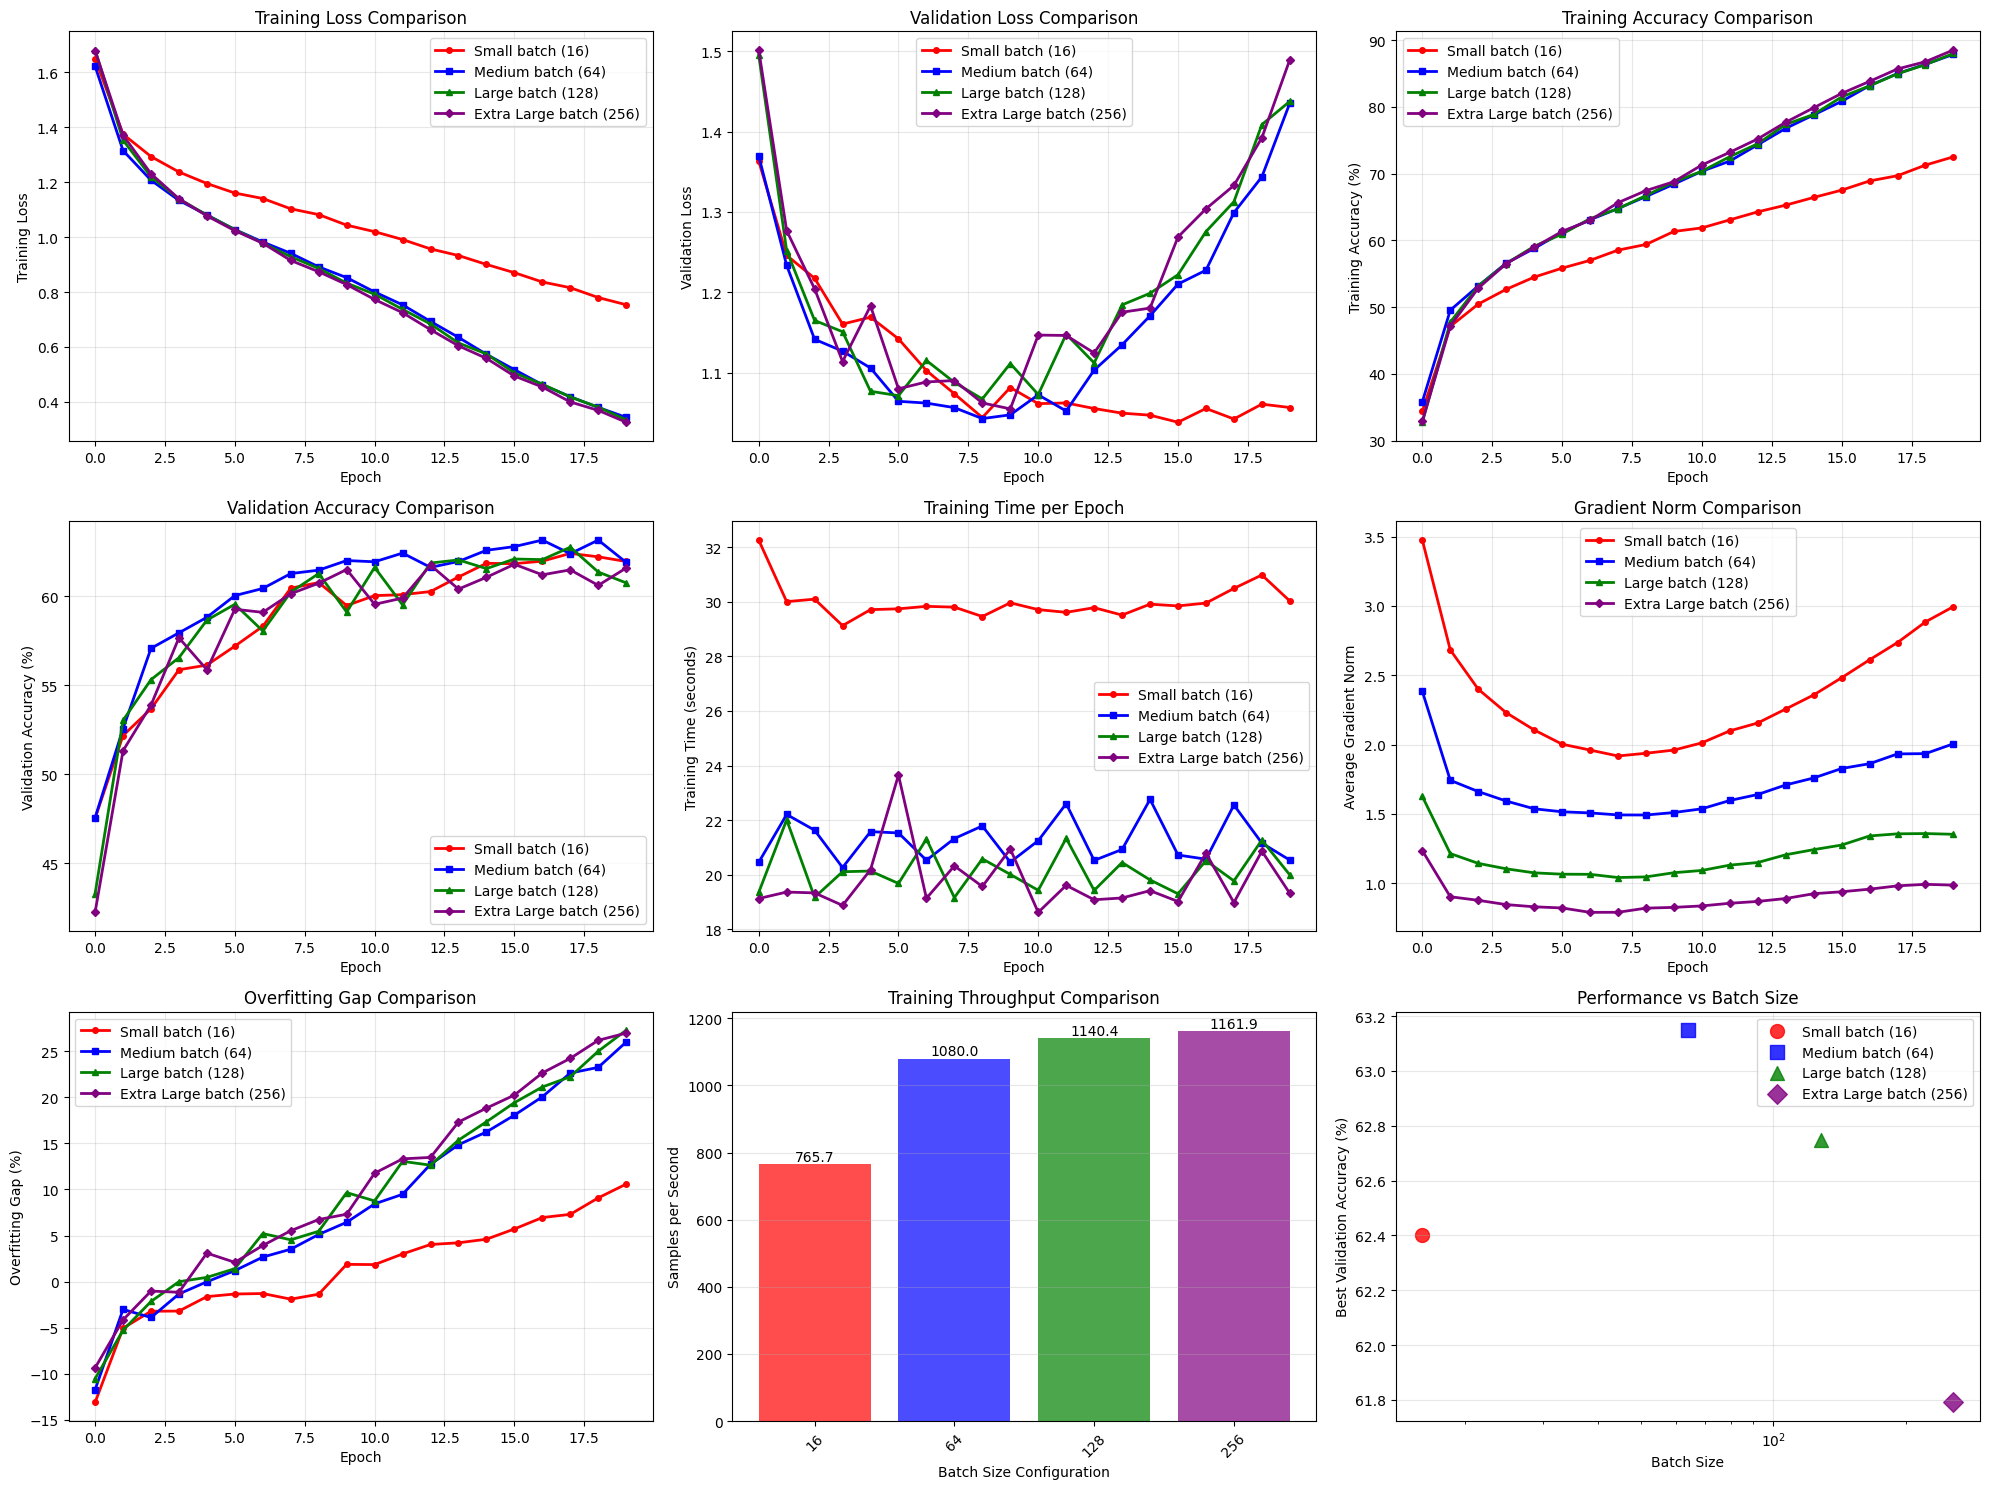

In [16]:
# Plot comprehensive comparison of all batch sizes
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Training Loss
for config_name, data in results.items():
    axes[0, 0].plot(data['train_losses'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
for config_name, data in results.items():
    axes[0, 1].plot(data['val_losses'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
for config_name, data in results.items():
    axes[0, 2].plot(data['train_accs'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Training Accuracy (%)')
axes[0, 2].set_title('Training Accuracy Comparison')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Validation Accuracy
for config_name, data in results.items():
    axes[1, 0].plot(data['val_accs'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Accuracy (%)')
axes[1, 0].set_title('Validation Accuracy Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Training Time per Epoch
for config_name, data in results.items():
    axes[1, 1].plot(data['train_times'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time per Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Gradient Norms
for config_name, data in results.items():
    axes[1, 2].plot(data['gradient_norms'], label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Average Gradient Norm')
axes[1, 2].set_title('Gradient Norm Comparison')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Overfitting Gap
for config_name, data in results.items():
    overfitting_gaps = [data['train_accs'][i] - data['val_accs'][i] for i in range(len(data['train_accs']))]
    axes[2, 0].plot(overfitting_gaps, label=data['config']['description'],
                   color=data['config']['color'], linewidth=2,
                   marker=data['config']['marker'], markersize=4)
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Overfitting Gap (%)')
axes[2, 0].set_title('Overfitting Gap Comparison')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Throughput (Samples per second)
batch_sizes = [results[config]['config']['batch_size'] for config in results.keys()]
throughputs = [len(train_dataset) / results[config]['avg_train_time'] for config in results.keys()]
colors = [results[config]['config']['color'] for config in results.keys()]
labels = [results[config]['config']['description'] for config in results.keys()]

bars = axes[2, 1].bar(range(len(batch_sizes)), throughputs, color=colors, alpha=0.7)
axes[2, 1].set_xlabel('Batch Size Configuration')
axes[2, 1].set_ylabel('Samples per Second')
axes[2, 1].set_title('Training Throughput Comparison')
axes[2, 1].set_xticks(range(len(batch_sizes)))
axes[2, 1].set_xticklabels([f'{bs}' for bs in batch_sizes], rotation=45)
axes[2, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, throughput in zip(bars, throughputs):
    axes[2, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{throughput:.1f}', ha='center', va='bottom')

# Performance vs Batch Size Scatter
best_accs = [results[config]['best_val_acc'] for config in results.keys()]
markers = [results[config]['config']['marker'] for config in results.keys()]

for i, (bs, acc, color, marker, label) in enumerate(zip(batch_sizes, best_accs, colors, markers, labels)):
    axes[2, 2].scatter(bs, acc, color=color, s=100, marker=marker, label=label, alpha=0.8)

axes[2, 2].set_xlabel('Batch Size')
axes[2, 2].set_ylabel('Best Validation Accuracy (%)')
axes[2, 2].set_title('Performance vs Batch Size')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)
axes[2, 2].set_xscale('log')

plt.tight_layout()
plt.show()

In [17]:
# Create detailed performance comparison table
summary_data = []
for config_name, data in results.items():
    config = data['config']
    summary_data.append({
        'Configuration': config['description'],
        'Batch Size': config['batch_size'],
        'Learning Rate': config['lr'],
        'Best Val Acc (%)': f"{data['best_val_acc']:.2f}",
        'Final Train Acc (%)': f"{data['final_train_acc']:.2f}",
        'Final Val Acc (%)': f"{data['final_val_acc']:.2f}",
        'Overfitting Gap (%)': f"{data['final_train_acc'] - data['final_val_acc']:.2f}",
        'Avg Train Time (s)': f"{data['avg_train_time']:.1f}",
        'Total Train Time (s)': f"{data['total_train_time']:.1f}",
        'Throughput (samples/s)': f"{len(train_dataset) / data['avg_train_time']:.1f}",
        'Avg Gradient Norm': f"{data['avg_gradient_norm']:.4f}",
        'Batches per Epoch': len(train_dataset) // config['batch_size']
    })

summary_df = pd.DataFrame(summary_data)
print("\nBatch Size Impact Summary:")
print("=" * 150)
print(summary_df.to_string(index=False))
print("=" * 150)


Batch Size Impact Summary:
          Configuration  Batch Size  Learning Rate Best Val Acc (%) Final Train Acc (%) Final Val Acc (%) Overfitting Gap (%) Avg Train Time (s) Total Train Time (s) Throughput (samples/s) Avg Gradient Norm  Batches per Epoch
       Small batch (16)          16         0.0010            62.40               72.53             61.95               10.58               30.0                599.9                  765.7            2.3635               1435
      Medium batch (64)          64         0.0010            63.15               87.89             61.89               25.99               21.3                425.3                 1080.0            1.7124                358
      Large batch (128)         128         0.0015            62.75               88.02             60.75               27.28               20.1                402.8                 1140.4            1.1986                179
Extra Large batch (256)         256         0.0020            61.79 

<Figure size 1500x1000 with 0 Axes>

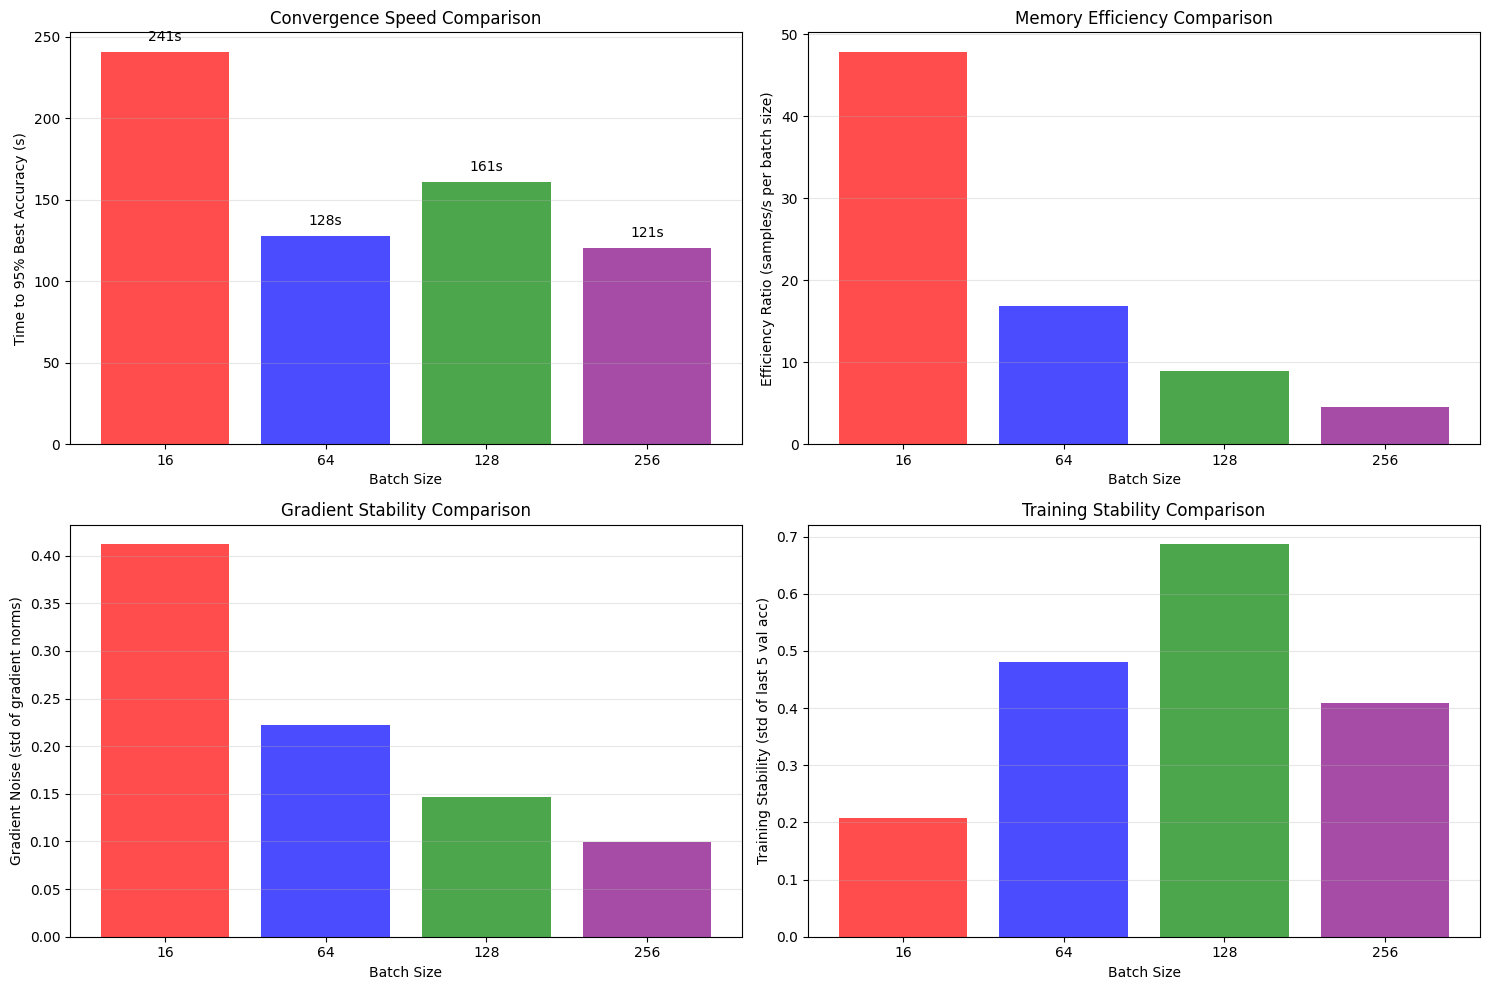

In [18]:
# Efficiency Analysis
plt.figure(figsize=(15, 10))

# Create 2x2 subplot for efficiency metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Time to Convergence
batch_sizes = [results[config]['config']['batch_size'] for config in results.keys()]
convergence_times = []

for config_name, data in results.items():
    # Find epoch where 95% of best accuracy was reached
    target_acc = 0.95 * data['best_val_acc']
    convergence_epoch = next((i for i, acc in enumerate(data['val_accs']) if acc >= target_acc), num_epochs)
    convergence_time = sum(data['train_times'][:convergence_epoch+1])
    convergence_times.append(convergence_time)

colors = [results[config]['config']['color'] for config in results.keys()]
bars1 = axes[0, 0].bar(range(len(batch_sizes)), convergence_times, color=colors, alpha=0.7)
axes[0, 0].set_xlabel('Batch Size')
axes[0, 0].set_ylabel('Time to 95% Best Accuracy (s)')
axes[0, 0].set_title('Convergence Speed Comparison')
axes[0, 0].set_xticks(range(len(batch_sizes)))
axes[0, 0].set_xticklabels([f'{bs}' for bs in batch_sizes])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, time_val in zip(bars1, convergence_times):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{time_val:.0f}s', ha='center', va='bottom')

# 2. Memory Efficiency (samples per second per batch size)
efficiency_ratio = [throughputs[i] / batch_sizes[i] for i in range(len(batch_sizes))]
bars2 = axes[0, 1].bar(range(len(batch_sizes)), efficiency_ratio, color=colors, alpha=0.7)
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].set_ylabel('Efficiency Ratio (samples/s per batch size)')
axes[0, 1].set_title('Memory Efficiency Comparison')
axes[0, 1].set_xticks(range(len(batch_sizes)))
axes[0, 1].set_xticklabels([f'{bs}' for bs in batch_sizes])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Gradient Noise (std of gradient norms)
gradient_stds = [np.std(data['gradient_norms']) for data in results.values()]
bars3 = axes[1, 0].bar(range(len(batch_sizes)), gradient_stds, color=colors, alpha=0.7)
axes[1, 0].set_xlabel('Batch Size')
axes[1, 0].set_ylabel('Gradient Noise (std of gradient norms)')
axes[1, 0].set_title('Gradient Stability Comparison')
axes[1, 0].set_xticks(range(len(batch_sizes)))
axes[1, 0].set_xticklabels([f'{bs}' for bs in batch_sizes])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Training Stability (std of validation accuracy in last 5 epochs)
stability_scores = [np.std(data['val_accs'][-5:]) for data in results.values()]
bars4 = axes[1, 1].bar(range(len(batch_sizes)), stability_scores, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].set_ylabel('Training Stability (std of last 5 val acc)')
axes[1, 1].set_title('Training Stability Comparison')
axes[1, 1].set_xticks(range(len(batch_sizes)))
axes[1, 1].set_xticklabels([f'{bs}' for bs in batch_sizes])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Best performing configuration: Medium batch (64)
Best validation accuracy: 63.15%
Batch size: 64
Learning rate: 0.001


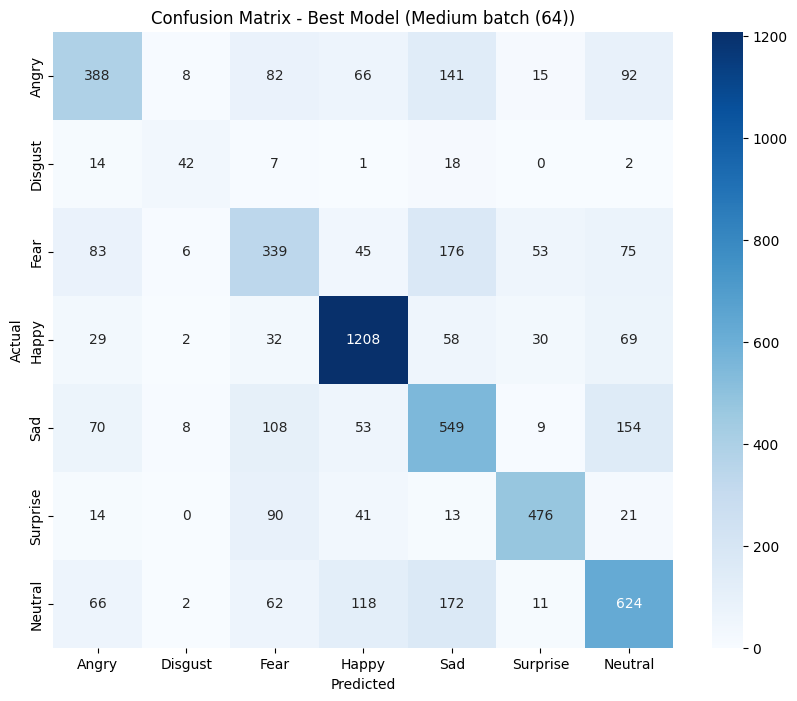

In [21]:
# Find best performing configuration
best_config = max(results.keys(), key=lambda x: results[x]['best_val_acc'])
best_model = results[best_config]['model']
best_config_details = results[best_config]['config']

print(f"\nBest performing configuration: {best_config_details['description']}")
print(f"Best validation accuracy: {results[best_config]['best_val_acc']:.2f}%")
print(f"Batch size: {best_config_details['batch_size']}")
print(f"Learning rate: {best_config_details['lr']}")

# Create validation loader with best batch size for final evaluation
final_val_loader = DataLoader(val_dataset, batch_size=best_config_details['batch_size'],
                             shuffle=False, num_workers=2)

# Load the best model and evaluate
best_model.load_state_dict(torch.load(f'best_{best_config.lower()}_model.pth'))
_, _, _, final_predictions, final_labels = validate_epoch(best_model, final_val_loader, nn.CrossEntropyLoss(), device)

# Confusion matrix for best model
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_config_details["description"]})')
plt.show()

In [22]:
# Classification report for best model
print(f"\nClassification Report - Best Model ({best_config_details['description']}):")
print("=" * 80)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))


Classification Report - Best Model (Medium batch (64)):
              precision    recall  f1-score   support

       Angry       0.58      0.49      0.53       792
     Disgust       0.62      0.50      0.55        84
        Fear       0.47      0.44      0.45       777
       Happy       0.79      0.85      0.82      1428
         Sad       0.49      0.58      0.53       951
    Surprise       0.80      0.73      0.76       655
     Neutral       0.60      0.59      0.60      1055

    accuracy                           0.63      5742
   macro avg       0.62      0.60      0.61      5742
weighted avg       0.63      0.63      0.63      5742



In [23]:
# Analyze batch size effects in detail
print("\nDetailed Batch Size Analysis:")
print("=" * 80)

for config_name, data in results.items():
    config = data['config']

    # Calculate various metrics
    convergence_speed = next((i for i, acc in enumerate(data['val_accs'])
                            if acc >= 0.9 * data['best_val_acc']), num_epochs)

    final_overfitting = data['final_train_acc'] - data['final_val_acc']
    max_overfitting = max([data['train_accs'][i] - data['val_accs'][i]
                          for i in range(len(data['train_accs']))])

    gradient_stability = np.std(data['gradient_norms'])
    loss_smoothness = np.std(np.diff(data['train_losses']))

    print(f"\n{config['description']} (Batch Size: {config['batch_size']}):")
    print(f"  Performance Metrics:")
    print(f"    - Best Validation Accuracy: {data['best_val_acc']:.2f}%")
    print(f"    - Final Overfitting Gap: {final_overfitting:.2f}%")
    print(f"    - Maximum Overfitting Gap: {max_overfitting:.2f}%")
    print(f"  \n  Training Dynamics:")
    print(f"    - Convergence Speed (90% best): Epoch {convergence_speed + 1}")
    print(f"    - Gradient Stability (std): {gradient_stability:.4f}")
    print(f"    - Loss Smoothness (std of diff): {loss_smoothness:.4f}")
    print(f"  \n  Efficiency Metrics:")
    print(f"    - Average Training Time: {data['avg_train_time']:.1f}s per epoch")
    print(f"    - Throughput: {len(train_dataset)/data['avg_train_time']:.1f} samples/s")
    print(f"    - Updates per Epoch: {len(train_dataset) // config['batch_size']}")
    print(f"    - Effective Learning Rate: {config['lr'] * config['batch_size']:.4f}")


Detailed Batch Size Analysis:

Small batch (16) (Batch Size: 16):
  Performance Metrics:
    - Best Validation Accuracy: 62.40%
    - Final Overfitting Gap: 10.58%
    - Maximum Overfitting Gap: 10.58%
  
  Training Dynamics:
    - Convergence Speed (90% best): Epoch 6
    - Gradient Stability (std): 0.4117
    - Loss Smoothness (std of diff): 0.0555
  
  Efficiency Metrics:
    - Average Training Time: 30.0s per epoch
    - Throughput: 765.7 samples/s
    - Updates per Epoch: 1435
    - Effective Learning Rate: 0.0160

Medium batch (64) (Batch Size: 64):
  Performance Metrics:
    - Best Validation Accuracy: 63.15%
    - Final Overfitting Gap: 25.99%
    - Maximum Overfitting Gap: 25.99%
  
  Training Dynamics:
    - Convergence Speed (90% best): Epoch 3
    - Gradient Stability (std): 0.2223
    - Loss Smoothness (std of diff): 0.0587
  
  Efficiency Metrics:
    - Average Training Time: 21.3s per epoch
    - Throughput: 1080.0 samples/s
    - Updates per Epoch: 358
    - Effective 

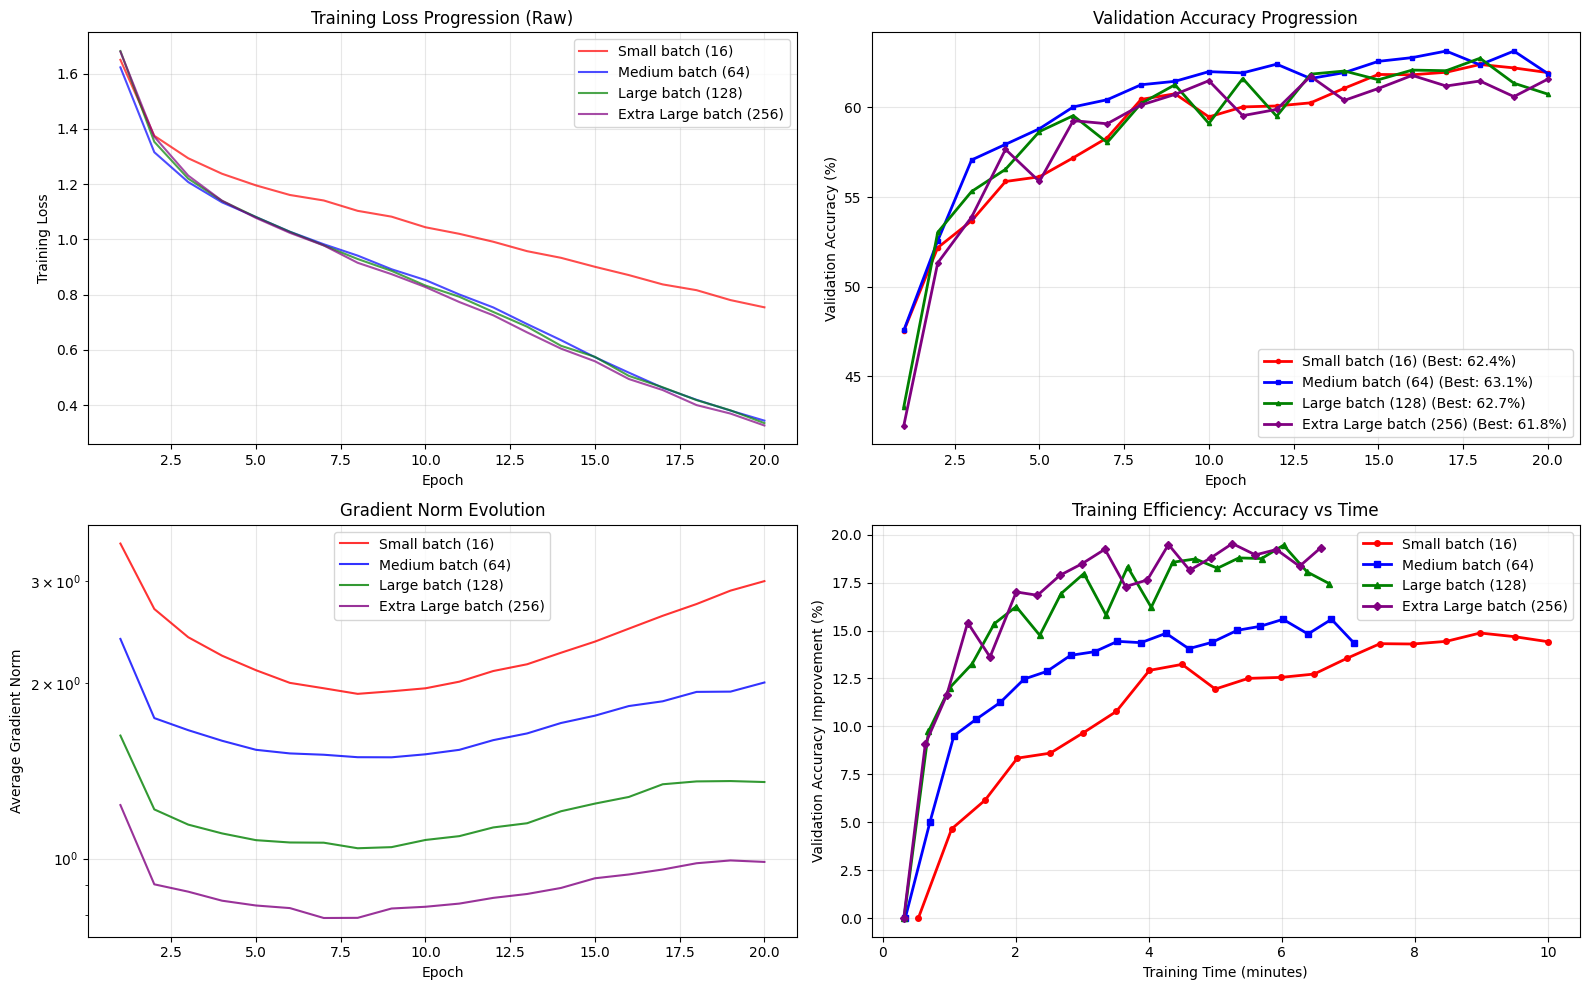

In [24]:
# Create learning curve comparison showing noise vs smoothness
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training loss curves (smoothed and raw)
for config_name, data in results.items():
    config = data['config']
    epochs = range(1, len(data['train_losses']) + 1)

    # Raw training loss
    axes[0, 0].plot(epochs, data['train_losses'],
                   label=f"{config['description']}",
                   color=config['color'], alpha=0.7, linewidth=1.5)

# Validation accuracy with confidence intervals
for config_name, data in results.items():
    config = data['config']
    epochs = range(1, len(data['val_accs']) + 1)

    axes[0, 1].plot(epochs, data['val_accs'],
                   label=f"{config['description']} (Best: {data['best_val_acc']:.1f}%)",
                   color=config['color'], linewidth=2,
                   marker=config['marker'], markersize=3)

axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss Progression (Raw)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Accuracy (%)')
axes[0, 1].set_title('Validation Accuracy Progression')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gradient norm evolution
for config_name, data in results.items():
    config = data['config']
    epochs = range(1, len(data['gradient_norms']) + 1)

    axes[1, 0].plot(epochs, data['gradient_norms'],
                   label=config['description'],
                   color=config['color'], linewidth=1.5, alpha=0.8)

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Average Gradient Norm')
axes[1, 0].set_title('Gradient Norm Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Training efficiency: Accuracy improvement per minute
for config_name, data in results.items():
    config = data['config']

    # Calculate cumulative time and accuracy improvement
    cumulative_time = np.cumsum(data['train_times']) / 60  # Convert to minutes
    accuracy_improvement = np.array(data['val_accs']) - data['val_accs'][0]

    axes[1, 1].plot(cumulative_time, accuracy_improvement,
                   label=config['description'],
                   color=config['color'], linewidth=2,
                   marker=config['marker'], markersize=4)

axes[1, 1].set_xlabel('Training Time (minutes)')
axes[1, 1].set_ylabel('Validation Accuracy Improvement (%)')
axes[1, 1].set_title('Training Efficiency: Accuracy vs Time')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Save all models and create final summary
for config_name in results.keys():
    torch.save(results[config_name]['model'].state_dict(),
               f'final_{config_name.lower()}_model.pth')

# Initialize final W&B run for comparison
wandb.init(
    project="fer-challenge",
    name="exp10-batch-size-comparison-summary",
    config={
        "experiment": "Batch Size Impact",
        "batch_sizes": [config['batch_size'] for config in batch_size_configs.values()],
        "dataset": "FER2013",
        "epochs": num_epochs,
        "architecture": "CNN with BatchNorm and Dropout"
    }
)

# Log comparison metrics
comparison_metrics = {}
for config_name, data in results.items():
    config = data['config']
    comparison_metrics.update({
        f"batch_{config['batch_size']}_best_val_acc": data['best_val_acc'],
        f"batch_{config['batch_size']}_final_train_acc": data['final_train_acc'],
        f"batch_{config['batch_size']}_final_val_acc": data['final_val_acc'],
        f"batch_{config['batch_size']}_avg_train_time": data['avg_train_time'],
        f"batch_{config['batch_size']}_throughput": len(train_dataset) / data['avg_train_time'],
        f"batch_{config,['batch_size']}_avg_gradient_norm": data['avg_gradient_norm']
    })

wandb.log(comparison_metrics)

# Save models to W&B
for config_name in results.keys():
    wandb.save(f'final_{config_name.lower()}_model.pth')
    wandb.save(f'best_{config_name.lower()}_model.pth')

In [26]:
# Final comprehensive analysis and recommendations
print("\n" + "=" * 90)
print("EXPERIMENT SUMMARY: BATCH SIZE IMPACT ANALYSIS")
print("=" * 90)

print(f"\nModel Architecture:")
print(f"  - 3 Convolutional Blocks with BatchNorm")
print(f"  - Conv channels: [64, 128, 256]")
print(f"  - FC layers: [512, 256, 7]")
print(f"  - Total Parameters: {total_params:,}")
print(f"  - Regularization: BatchNorm + Dropout")

print(f"\nBatch Size Configurations Tested:")
for name, config in batch_size_configs.items():
    print(f"  - {config['description']}: {config['batch_size']} (LR: {config['lr']})")

print(f"\nPerformance Rankings (by Best Validation Accuracy):")
sorted_configs = sorted(results.items(), key=lambda x: x[1]['best_val_acc'], reverse=True)
for rank, (config_name, data) in enumerate(sorted_configs, 1):
    config = data['config']
    convergence_epoch = next((i for i, acc in enumerate(data['val_accs'])
                            if acc >= 0.95 * data['best_val_acc']), num_epochs) + 1
    print(f"  {rank}. {config['description']}: {data['best_val_acc']:.2f}% (Converged: Epoch {convergence_epoch})")

print(f"\nEfficiency Rankings (by Throughput):")
sorted_by_throughput = sorted(results.items(),
                            key=lambda x: len(train_dataset) / x[1]['avg_train_time'],
                            reverse=True)
for rank, (config_name, data) in enumerate(sorted_by_throughput, 1):
    config = data['config']
    throughput = len(train_dataset) / data['avg_train_time']
    print(f"  {rank}. {config['description']}: {throughput:.1f} samples/s")

print(f"\nKey Observations:")
best_perf_config = sorted_configs[0][0]
best_eff_config = sorted_by_throughput[0][0]
worst_perf_config = sorted_configs[-1][0]

performance_gap = (results[best_perf_config]['best_val_acc'] -
                  results[worst_perf_config]['best_val_acc'])

print(f"  - Best performing batch size: {results[best_perf_config]['config']['batch_size']}")
print(f"  - Most efficient batch size: {results[best_eff_config]['config']['batch_size']}")
print(f"  - Performance gap between best and worst: {performance_gap:.2f}%")

# Calculate gradient noise correlation
batch_sizes_list = [results[config]['config']['batch_size'] for config in results.keys()]
gradient_stds = [np.std(results[config]['gradient_norms']) for config in results.keys()]
noise_correlation = np.corrcoef(np.log(batch_sizes_list), gradient_stds)[0, 1]
print(f"  - Gradient noise correlation with batch size: {noise_correlation:.3f}")

# Find most stable training
stability_scores = {config: np.std(data['val_accs'][-5:]) for config, data in results.items()}
most_stable = min(stability_scores.keys(), key=lambda x: stability_scores[x])
print(f"  - Most stable training: {results[most_stable]['config']['description']}")

print(f"\nBatch Size Effects Analysis:")
print(f"  Small Batches (16-32):")
small_configs = [k for k, v in results.items() if v['config']['batch_size'] <= 32]
if small_configs:
    small_data = results[small_configs[0]]
    print(f"    - Higher gradient noise: {np.std(small_data['gradient_norms']):.4f}")
    print(f"    - More frequent updates: {len(train_dataset) // small_data['config']['batch_size']} per epoch")
    print(f"    - Better generalization potential")

print(f"  Large Batches (128+):")
large_configs = [k for k, v in results.items() if v['config']['batch_size'] >= 128]
if large_configs:
    large_data = results[large_configs[0]]
    print(f"    - Lower gradient noise: {np.std(large_data['gradient_norms']):.4f}")
    print(f"    - Fewer updates: {len(train_dataset) // large_data['config']['batch_size']} per epoch")
    print(f"    - Higher computational efficiency")
    print(f"    - Potential for faster convergence with proper LR scaling")

print(f"\nMemory and Computational Trade-offs:")
min_time = min(data['avg_train_time'] for data in results.values())
max_time = max(data['avg_train_time'] for data in results.values())
print(f"  - Training time range: {min_time:.1f}s - {max_time:.1f}s per epoch")
print(f"  - Speedup from optimal batch size: {max_time/min_time:.2f}x")

# GPU utilization estimate
for config_name, data in results.items():
    config = data['config']
    theoretical_throughput = len(train_dataset) / (len(train_dataset) // config['batch_size']) * config['batch_size']
    actual_throughput = len(train_dataset) / data['avg_train_time']
    efficiency = actual_throughput / theoretical_throughput * 100

print(f"\nRecommendations:")
if results[best_perf_config]['config']['batch_size'] <= 64:
    print(f"  - For best accuracy: Use moderate batch sizes (16-64) for better generalization")
else:
    print(f"  - For best accuracy: Large batches work well with proper LR scaling")

if results[best_eff_config]['config']['batch_size'] >= 128:
    print(f"  - For efficiency: Use larger batch sizes (128+) for faster training")
else:
    print(f"  - For efficiency: Medium batch sizes provide good speed-accuracy balance")

print(f"  - Consider gradient accumulation for very large effective batch sizes")
print(f"  - Adjust learning rate proportionally with batch size (linear scaling rule)")
print(f"  - Monitor gradient norms to detect optimization issues")
print(f"  - Use learning rate warmup for large batch training")

print(f"\nOptimal Configuration for this Task:")
optimal_config = results[best_perf_config]['config']
print(f"  - Batch Size: {optimal_config['batch_size']}")
print(f"  - Learning Rate: {optimal_config['lr']}")
print(f"  - Expected Accuracy: {results[best_perf_config]['best_val_acc']:.2f}%")
print(f"  - Training Time: {results[best_perf_config]['avg_train_time']:.1f}s per epoch")
print(f"  - Throughput: {len(train_dataset)/results[best_perf_config]['avg_train_time']:.1f} samples/s")

wandb.finish()


EXPERIMENT SUMMARY: BATCH SIZE IMPACT ANALYSIS

Model Architecture:
  - 3 Convolutional Blocks with BatchNorm
  - Conv channels: [64, 128, 256]
  - FC layers: [512, 256, 7]
  - Total Parameters: 5,999,815
  - Regularization: BatchNorm + Dropout

Batch Size Configurations Tested:
  - Small batch (16): 16 (LR: 0.001)
  - Medium batch (64): 64 (LR: 0.001)
  - Large batch (128): 128 (LR: 0.0015)
  - Extra Large batch (256): 256 (LR: 0.002)

Performance Rankings (by Best Validation Accuracy):
  1. Medium batch (64): 63.15% (Converged: Epoch 6)
  2. Large batch (128): 62.75% (Converged: Epoch 8)
  3. Small batch (16): 62.40% (Converged: Epoch 8)
  4. Extra Large batch (256): 61.79% (Converged: Epoch 6)

Efficiency Rankings (by Throughput):
  1. Extra Large batch (256): 1161.9 samples/s
  2. Large batch (128): 1140.4 samples/s
  3. Medium batch (64): 1080.0 samples/s
  4. Small batch (16): 765.7 samples/s

Key Observations:
  - Best performing batch size: 64
  - Most efficient batch size: 25

"batch_({'batch_size': 128, 'lr': 0.0015, 'description': 'Large batch (128)', 'color': 'green', 'marker': '^'}, ['batch_size'])_avg_gradient_norm",▁
"batch_({'batch_size': 16, 'lr': 0.001, 'description': 'Small batch (16)', 'color': 'red', 'marker': 'o'}, ['batch_size'])_avg_gradient_norm",▁
"batch_({'batch_size': 256, 'lr': 0.002, 'description': 'Extra Large batch (256)', 'color': 'purple', 'marker': 'D'}, ['batch_size'])_avg_gradient_norm",▁
"batch_({'batch_size': 64, 'lr': 0.001, 'description': 'Medium batch (64)', 'color': 'blue', 'marker': 's'}, ['batch_size'])_avg_gradient_norm",▁
batch_128_avg_train_time,▁
batch_128_best_val_acc,▁
batch_128_final_train_acc,▁
batch_128_final_val_acc,▁
batch_128_throughput,▁
batch_16_avg_train_time,▁
batch_16_best_val_acc,▁
